# Sentiment Time Series Generation

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
import random
import ast
from transformers import pipeline
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

2023-02-13 00:43:24.056320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 00:43:24.287259: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 00:43:24.287280: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-02-13 00:43:25.143791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-13 00:43:25.143861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-13 00:43:25.143870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [4]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,14308,"[""Make yaself, Don't break yaself"", ""Make yase...",pop,14308,"['Make Problems, Then Let Them', 'Make peace, ...","[""We've been living in a fantasy"", ""I said we'..."
1,36771,"['You will always be my baby', ""There's a thou...",pop,36771,"['You shall long be my baby', ""There's a thous...","['I still see your coat hangin on the door', '..."
2,33221,"['Hard to find a way to get through', ""It's a ...",pop,33221,"['Hard times find another way to cut through',...","['relaxin maxin to the maximum', 'to tracks a ..."
3,31036,"[""We're boarding the night train"", ""We're bore...",pop,31036,"[""We're behind the first train"", ""We're bored ...","[""Early mornin' wake up"", 'Gently with the Car..."
4,10925,"['Come come baby', 'I can see you wanna touch ...",pop,10925,"['Come come come', 'I wanna see people wanna t...",['I hear the click-clack of your feet on the s...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           150 non-null    int64 
 1   lyrics          150 non-null    object
 2   genre           150 non-null    object
 3   id              150 non-null    int64 
 4   similar_lyrics  150 non-null    object
 5   random_lyrics   150 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.2+ KB


In [6]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))
df['similar_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['similar_lyrics']))
df['random_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['random_lyrics']))

In [7]:
random.choice(df['lyrics'])

['Yea, yea, yea',
 " It's B2K ya'll",
 'Welcome ladies... and gentlemen',
 ' To the U Got Served Soundtrack',
 ' We about to do dis',
 'You know how we get down',
 'Oh Yea',
 'You know dat',
 'come on',
 'Omarion hit em wit it',
 'Like whoa',
 'You know',
 "Girl you're the star of my show",
 'In this club',
 'Poppin bub',
 'The way you shakin deservin some dubs',
 'Turn around',
 'Make it bounce',
 'Shake it like you come from out of town',
 'Whats yo name?',
 'Whats yo sign?',
 'Girl you leavin with me tonight',
 'Mami shake it like you care for me',
 'You know I like it when you do that little dance for me',
 "Mami I'm just trynna get you in my room",
 'And see that big badabing go badaboom',
 'This one, I seen',
 "Couldn't believe the ass in them jeans",
 'To myself, had to think',
 "'Any room for me up in them jeans?'",
 'Ghetto star',
 'You are',
 'Eat you up like a chocolate bar',
 "What's yo name?",
 "What's yo sign?",
 'Damn you got me weeping inside',
 'Mami shake it like you 

In [8]:
toy_lyrics = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
toy_lyrics.head()

,lyrics,part
0,"Yo, listen up, I got a story to tell",intro
1,"Gonna take you on a journey, can you feel?",intro
2,"I was born in the ghetto, raised in the streets",verse
3,"Never had much, but I made it with heat",verse
4,"I fought for my dreams, never gave up the fight",verse


In [9]:
eg_lyrics = list(toy_lyrics['lyrics'])
eg_lyrics

['Yo, listen up, I got a story to tell',
 'Gonna take you on a journey, can you feel?',
 'I was born in the ghetto, raised in the streets',
 'Never had much, but I made it with heat',
 'I fought for my dreams, never gave up the fight',
 "Now I'm living my best life, shining bright",
 "Yeah, yeah, I'm the one, hear my voice",
 'got the fire, gonna make some noise',
 "I'm the master of the game, that's a fact",
 'got the skills, never looking back',
 "I've been through the ups and the downs, the twists and the turns",
 'But I always keep my head up, never letting my fire burn',
 "I've got the power, got the drive, never gonna stop",
 'Gonna make my mark, till the beat drops',
 "Yeah, yeah, I'm the one, hear my voice",
 'got the fire, gonna make some noise',
 "I'm the master of the game, that's a fact",
 'got the skills, never looking back',
 'So listen up, hear what I say',
 "I'm the king of the game, leading the way",
 "With my rhymes, and my flows, I'm unstoppable",
 "Gonna take the wo

## Sentiment

In [10]:
sent_pipeline = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")

In [11]:
sentences = ['I love you', 'I hate you', 'I am going to the store to buy some milk.']

model_output = sent_pipeline(sentences)
model_output

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079},
 {'label': 'NEGATIVE', 'score': 0.9932184815406799}]

In [12]:
def get_unique_sentiment(sentiment_output):
    # Map sentiment in a unique value ranging [-1,1]
    unique_sentiments = []
    for so in sentiment_output:
        if so['label'] == 'POSITIVE':
            pos = so['score']
            neg = 1 - pos
        else:
            neg = so['score']
            pos = 1- neg
        unique_sentiments.append(pos - neg)
    return unique_sentiments

In [13]:
unique_scores = get_unique_sentiment(model_output)
list(zip(sentences, unique_scores))

[('I love you', 0.9997313022613525),
 ('I hate you', -0.9982258081436157),
 ('I am going to the store to buy some milk.', -0.9864369630813599)]

In [14]:
eg_sentibert_ts = get_unique_sentiment(sent_pipeline(eg_lyrics))

In [15]:
parts_of_lyrics = list(toy_lyrics['part'])
color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(parts_of_lyrics))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

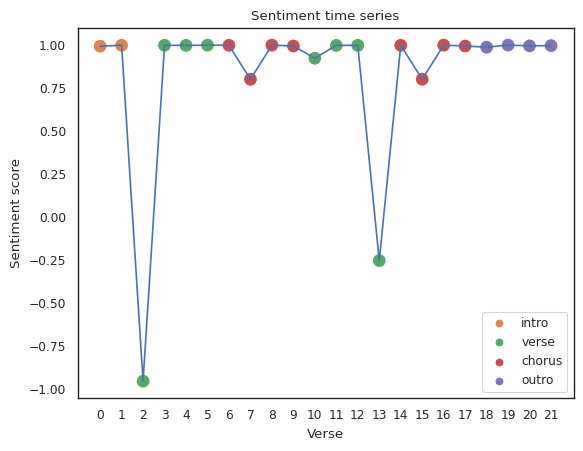

In [16]:
fig, ax = plt.subplots()
ax = plt.plot(eg_sentibert_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_sentibert_ts, 
                     x = range(len(eg_sentibert_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_sentibert_ts)))
ax.set_xlabel('Verse')
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment time series')
tikzplotlib.save('../tikz/sentibert_ts.tex')

In [17]:
sentibert_ts = [get_unique_sentiment(sent_pipeline(lyrics)) for lyrics in df['lyrics']]

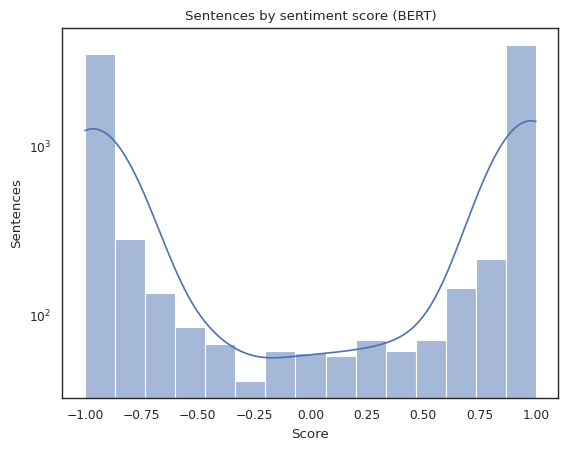

In [18]:
bert_scores = [score for sb_ts in sentibert_ts for score in sb_ts]

fig, ax = plt.subplots()
ax = sns.histplot(bert_scores, kde=True)
ax.set_xlabel('Score')
ax.set_ylabel('Sentences')
ax.set_yscale('log')
ax.set_title('Sentences by sentiment score (BERT)')
tikzplotlib.save('../tikz/hist_sentibert.tex')

In [19]:
# VADER model
sid = SentimentIntensityAnalyzer()

for sentence in sentences:
    print(sentence, sid.polarity_scores(sentence)['compound'])

I love you 0.6369
I hate you -0.5719
I am going to the store to buy some milk. 0.0


In [20]:
generate_vader_ts = lambda lyrics: [sid.polarity_scores(verse)['compound'] for verse in lyrics]

eg_sentivader_ts = generate_vader_ts(eg_lyrics)

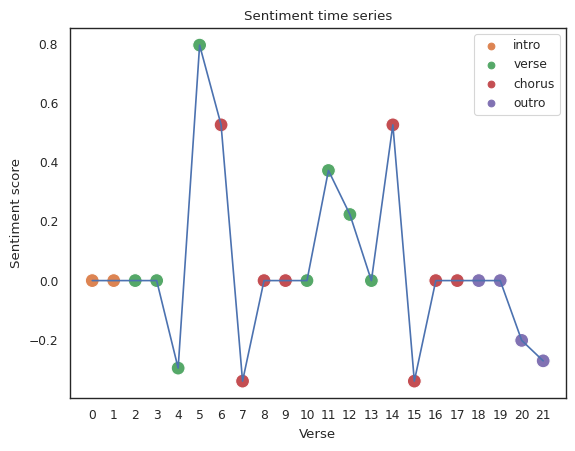

In [21]:
fig, ax = plt.subplots()
ax = plt.plot(eg_sentivader_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_sentivader_ts, 
                     x = range(len(eg_sentivader_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_sentivader_ts)))
ax.set_xlabel('Verse')
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment time series')
tikzplotlib.save('../tikz/sentivader_ts.tex')

In [22]:
vader_sen_ts = []

for lyrics in df['lyrics']:
    vader_sen_ts.append([sid.polarity_scores(verse)['compound'] for verse in lyrics])

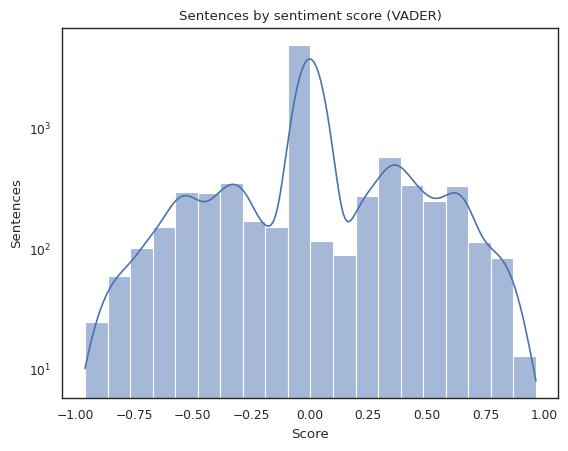

In [23]:
vader_scores = [score for vst in vader_sen_ts for score in vst]

fig, ax = plt.subplots()
ax = sns.histplot(vader_scores, kde=True, bins=20)
ax.set_xlabel('Score')
ax.set_ylabel('Sentences')
ax.set_title('Sentences by sentiment score (VADER)')
ax.set_yscale('log')
tikzplotlib.save('../tikz/hist_sentivader.tex')

In [24]:
corr = np.corrcoef(vader_scores, bert_scores)[0, 1]

print(f'Correlation VADER and BERT sentiment scores: {corr}')

Correlation VADER and BERT sentiment scores: 0.3403170377694129


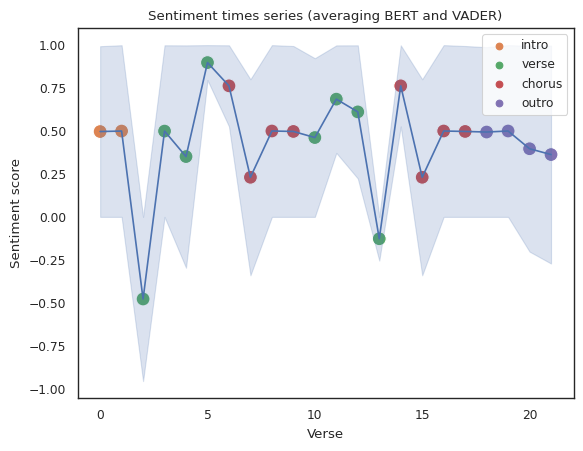

In [25]:
fig, ax = plt.subplots()
# Compute mean for basic scatteplot
eg_sent_ts = np.mean(np.column_stack((eg_sentibert_ts, eg_sentivader_ts)), axis=1)
ax = sns.scatterplot(y = eg_sent_ts, 
                     x = range(len(eg_sent_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
# Create a DataFrame for lineplot
data = {'sentiment': eg_sentibert_ts + eg_sentivader_ts,
        'model': ['bert'] * len(eg_sentibert_ts) + ['vader'] * len(eg_sentivader_ts),
        'timestamp': list(range(0,len(eg_sentibert_ts))) + list(range(0,len(eg_sentivader_ts)))}
eg_sent_ts = pd.DataFrame(data)
ax = sns.lineplot(data=eg_sent_ts, x='timestamp', y='sentiment')
ax.set_xlabel('Verse')
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment times series (averaging BERT and VADER)')
tikzplotlib.save('../tikz/sentiment_ts.tex')

In [26]:
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    ts_data[lyrics_type] = []
    for lyr in df[lyrics_type]:
        sentibert_ts = get_unique_sentiment(sent_pipeline(lyr))
        sentivader_ts = generate_vader_ts(lyr)
        sentiment_ts = np.mean(np.column_stack((sentibert_ts, sentivader_ts)), axis=1)
        sentiment_ts = list(sentiment_ts)
        ts_data[lyrics_type].append(sentiment_ts)        
ts_data = pd.DataFrame(ts_data)
filename = f'../data/evaluation/time-series/sentiment_ts.csv'
ts_data.to_csv(filename, index=False)

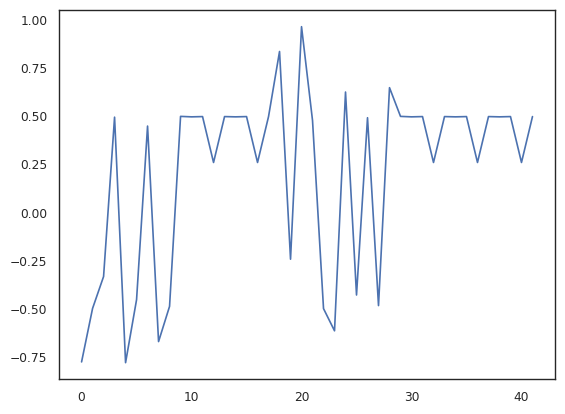

In [27]:
plt.plot(random.choice(ts_data['lyrics']))

## Emotion

In [28]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [29]:
def get_logits(sentence, tokenizer, model, to_numpy=False):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    if to_numpy:
        return logits[0].numpy()
    else:
        return logits

In [30]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [31]:
sentences = ["I am so happy right now!",            
            "What a beautiful surprise!.",
            "This news made me feel so worried.",
            "I am so excited for my vacation!",
            "I am feeling really calm and content.",
            "That smell is making me feel so disgusted.",
            "I am going to the store to buy some milk"]

In [32]:
logits_tensor = [get_logits(sentence, tokenizer=tokenizer, model=model) for sentence in sentences]
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [33]:
labels

['joy', 'joy', 'fear', 'joy', 'joy', 'disgust', 'neutral']

In [34]:
eg_multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, model=model, to_numpy=True) for verse in eg_lyrics])

In [35]:
logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in eg_lyrics]
labels = [logits2label(lt, model=model) for lt in logits_tensor]

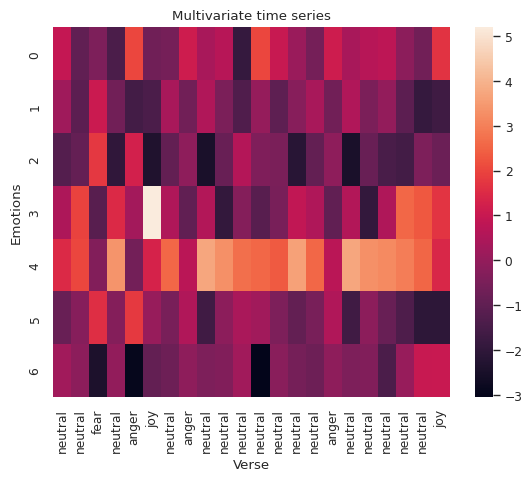

In [36]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_xlabel('Verse')
ax.set_ylabel('Emotions')
ax.set_title('Multivariate time series')
ax.set_xticklabels(labels, rotation=90)
tikzplotlib.save('../tikz/emotion_multi_ts.tex')

In [37]:
global_scaler = joblib.load('../models/emo_scaler.pkl')
global_pca = joblib.load('../models/emo_pca.pkl')

In [38]:
pca_output = global_pca.transform(global_scaler.transform(eg_multi_ts))

eg_uni_ts = np.array(list(
    map(lambda unique_element: unique_element[0], pca_output)))

In [39]:
color_map = {}
for idx, label in enumerate(list(dict.fromkeys(labels))):    
    # Map color excluding first color of the palette 
    color_map[label] = sns.color_palette()[idx+1]

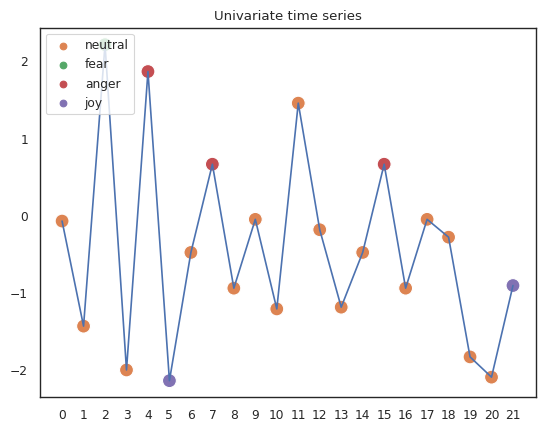

In [40]:
fig, ax = plt.subplots()
ax = plt.plot(eg_uni_ts)
# Draw dots representing parts of the lyrics
ax =  sns.scatterplot(y = eg_uni_ts,
                      x = range(len(eg_uni_ts)),
                      hue=labels, s=100,
                      palette=color_map)

ax.set_title('Univariate time series')
ax.set_xticks(range(len(eg_uni_ts)))

plt.legend(loc='upper left')
tikzplotlib.save('../tikz/emotion_uni_ts_gpca.tex')


In [41]:
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    ts_data[lyrics_type] = []
    for lyr in df[lyrics_type]:
        multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, 
                             model=model, to_numpy=True) for verse in lyr])
        scl_multi_ts = global_scaler.transform(multi_ts)
        pca_output = global_pca.transform(scl_multi_ts)
        emotion_ts = list(
            map(lambda unique_element: unique_element[0], pca_output))        
        ts_data[lyrics_type].append(emotion_ts)        
ts_data = pd.DataFrame(ts_data)
filename = f'../data/evaluation/time-series/emotion_ts.csv'
ts_data.to_csv(filename, index=False)

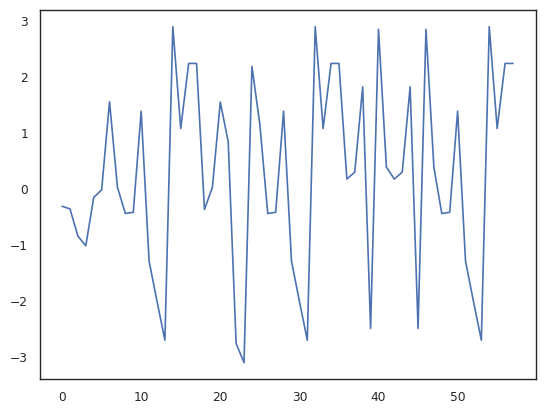

In [42]:
plt.plot(random.choice(ts_data['lyrics']))